In [1]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
// Evitar autoscroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

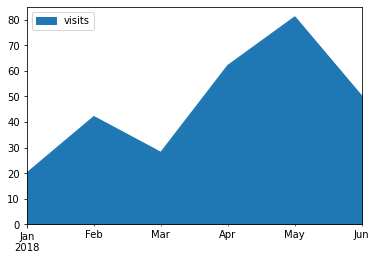

In [7]:
import pandas as pd
df = pd.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6],
    'signups': [5, 5, 6, 12, 14, 13],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2018/01/01', end='2018/07/01',
                       freq='M'))
ax = df.plot.area(y='visits')

In [25]:
# a = [1,2,3]
# b = [4,5,6]
# zipped_list = zip(a,b)
zipped_list=[(1, 4), (3, 5), (2, 6)]
zipped_list
unzipped_list=list(zip(*zipped_list))
unzipped_list
list(unzipped_list[0])
list(unzipped_list[1])

[(1, 4), (3, 5), (2, 6)]

[(1, 3, 2), (4, 5, 6)]

[1, 3, 2]

[4, 5, 6]

In [36]:
p=[(1, 4), (3, 5), (2, 6)]

p.sort()
p

p=list(zip(*p))
p

p=[list(p[0]),list(p[1])]
p

[(1, 4), (2, 6), (3, 5)]

[(1, 2, 3), (4, 6, 5)]

[[1, 2, 3], [4, 6, 5]]

In [249]:
import numpy as np
# from toolbox import *
import toolbox as tb
from skeleton import *
import pandas as pd
from gensim.models import FastText
%load_ext autoreload
%autoreload 2
import os
import tqdm
from microtc.utils import tweet_iterator
import datetime
from collections import Counter
import gc
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
class Tokens():
    tokenized_pointer=None
    
    def tokenize(self,json_file,npy_file=None,replace=False,showProgressEach=1000):
        self.npy_file=str(os.path.splitext(json_file)[0]+".npy") if not npy_file else npy_file

        if not replace and os.path.isfile(self.npy_file):
            print(f"** Replace is off. {os.path.abspath(self.npy_file)} already exists, then load.")
        else:
            tokenized_docs=[]
            self.N=0
            print(f"** Processing {json_file} ...")
            tx = datetime.datetime.now()
            for idx, tw in enumerate(tweet_iterator(json_file)):
                tb.show_progress(showProgressEach, tx, idx)
                twTokens = tb.process_line(tw['text']) # Tokenizando tweet.
                tokenized_docs.append(twTokens)
            self.N=idx+1
        
            maxLen=len(max(tokenized_docs))
            for i, doc in enumerate(tokenized_docs):
                tokenized_docs[i]=[doc[x] if x<len(doc) else '' for x in range(maxLen)]
            
            np.save(self.npy_file,tokenized_docs)
            del(tokenized_docs)
            gc.collect()
            print(f"** Processed {self.N} lines. Saved to {os.path.abspath(self.npy_file)}.")
        
        self.pointer=np.load(self.npy_file, mmap_mode='r')
        return self
    
    def get(self,n):
        return [x for x in self.pointer[n,:] if x != '']

In [294]:
tokens=Tokens().tokenize("data/geo-mx-2004_min.json",replace=True,showProgressEach=1000)

** Processing data/geo-mx-2004_min.json ...
2020-05-12 04:16:13.837646 :: 0.000268 - Processing item #0 
2020-05-12 04:16:14.645067 :: 0.807689 - Processing item #1000 
2020-05-12 04:16:15.434716 :: 1.597338 - Processing item #2000 
2020-05-12 04:16:16.186902 :: 2.349524 - Processing item #3000 
2020-05-12 04:16:16.954268 :: 3.11689 - Processing item #4000 
2020-05-12 04:16:17.718908 :: 3.88153 - Processing item #5000 
2020-05-12 04:16:18.520565 :: 4.683187 - Processing item #6000 
2020-05-12 04:16:19.273667 :: 5.436289 - Processing item #7000 
2020-05-12 04:16:20.043023 :: 6.205645 - Processing item #8000 
2020-05-12 04:16:20.851780 :: 7.014402 - Processing item #9000 
** Processed 10000 lines. Saved to /home/jovyan/public/B6_ProyectoIntegrador/data/geo-mx-2004_min.npy.


In [298]:
class Index():
#     vocab = None
    N = 0
    DF = Counter({})
    TF = []
    
#     def __init__(self):
#         return self

    def computePostingLists(self, tokens, showProgressEach=1000):
        print("** Counting TF & DF ...")
        tx = datetime.datetime.now()
        for idx in range(tokens.N):
            tb.show_progress(showProgressEach,tx,idx)
            
            tok=tokens.get(idx)
            # Sumando frecuencias individiales.
            twCnt = Counter(tok)
            
            self.TF.append(twCnt)
            
            # Sumando frecuencias por documento (DF).
            self.DF.update(list(twCnt.keys()))

            # Contabilizando documentos.
            self.N += 1
            
#         words = self.DF.keys()
#         self.vocab = dict(zip(words, range(len(words))))
#         self.DF_vec = cnt2vec(self.DF, self.vocab)
#         self.IDF_vec = np.log2(self.N / (self.DF_vec + 1))
        
#         # Calculando TF-IDF y asignando a usuarios.
#         for userId in self.users:
#             TF_cnt = self.users[userId]
#             self.users[userId] = cnt2vec(TF_cnt, self.vocab) * self.IDF_vec
        self.postlists=defaultdict(list)
    
#         print(self.TF)
#         print(self.DF)
        
#         print(">>>>>>>>>>N=",self.N)
        print("** Calculating TF-IDF...")
        for i,c in enumerate(self.TF):
            tb.show_progress(showProgressEach,tx,i)
#             print("i,c ->",i,c)
            for w,tf in c.items():
#                 if tf>1:print("w,tf,df ->",w,tf,self.DF[w])                
#                 if tf>1:print("Before:",self.postlists[w])
#                 tup=(tf*np.log2(self.N/(self.DF[w]+1)),i)
#                 if tf>1:print(tup)
                self.postlists[w].append((tf*np.log2(self.N/(self.DF[w]+1)),i))
#                 if tf>1:print("after:",self.postlists[w])
#         print(postlists)
        print("** Sorting posting lists...")
        for idx,(w,p) in enumerate(self.postlists.items()):
            tb.show_progress(showProgressEach,tx,idx)
#             print("Before:",w,p)
            p.sort()
            p=list(zip(*p))
            self.postlists[w]=[list(p[1]),list(p[0])]
#             print("After:",w,p)
        return self

    def getX(self):
        return np.array([self.users[key] for key in self.users])
    
    def cluster(self, n_clusters=9):
        self.cluster = KMeans(n_clusters=n_clusters, n_jobs=4).fit(self.getX())
        return self.cluster

In [299]:
index_=Index().computePostingLists(tokens,showProgressEach=1000)
# index_.postlists

** Counting TF & DF ...
2020-05-12 04:21:14.924722 :: 1.3e-05 - Processing item #0 
2020-05-12 04:21:14.999789 :: 0.07508 - Processing item #1000 
2020-05-12 04:21:15.060391 :: 0.135682 - Processing item #2000 
2020-05-12 04:21:15.122341 :: 0.197632 - Processing item #3000 
2020-05-12 04:21:15.190243 :: 0.265534 - Processing item #4000 
2020-05-12 04:21:15.252786 :: 0.328077 - Processing item #5000 
2020-05-12 04:21:15.314147 :: 0.389438 - Processing item #6000 
2020-05-12 04:21:15.563224 :: 0.638515 - Processing item #7000 
2020-05-12 04:21:15.642949 :: 0.71824 - Processing item #8000 
2020-05-12 04:21:15.717736 :: 0.793027 - Processing item #9000 
** Calculating TF-IDF...
2020-05-12 04:21:15.797516 :: 0.872807 - Processing item #0 
2020-05-12 04:21:15.839069 :: 0.91436 - Processing item #1000 
2020-05-12 04:21:15.879027 :: 0.954318 - Processing item #2000 
2020-05-12 04:21:15.941657 :: 1.016948 - Processing item #3000 
2020-05-12 04:21:15.991554 :: 1.066845 - Processing item #4000 
2

In [ ]:
index_.post

In [238]:
cnt=Counter(['a','b','a','c','c','c'])
cnt

Counter({'a': 2, 'b': 1, 'c': 3})

In [255]:
cnt['a']

2

In [234]:
import sys
local_vars = list(locals().items())
tot=0
vars_=[]
for var, obj in local_vars:
    mem=sys.getsizeof(obj)
    tot+=mem
    vars_.append((mem,var))
print("Total =",tot)
vars_.sort(reverse=True)
print(vars_)

Total = 132888
[(3512, 'local_vars'), (3312, 'vars_'), (2904, 'stop_words'), (2288, '_oh'), (2288, 'Out'), (2224, '_ih'), (2224, 'In'), (1867, '_i227'), (1862, '_i224'), (1856, '_i210'), (1848, '_i208'), (1846, '_i212'), (1757, '_i206'), (1656, '_i204'), (1628, '_i202'), (1623, '_i200'), (1573, '_i198'), (1516, '_i53'), (1438, '_i51'), (1436, '_i195'), (1433, '_i49'), (1431, '_i192'), (1431, '_i190'), (1429, '_i188'), (1429, '_i187'), (1423, '_i47'), (1403, '_i181'), (1402, '_i184'), (1402, '_i183'), (1382, '_i179'), (1345, '_i176'), (1345, '_i173'), (1335, '_i45'), (1332, '_i43'), (1284, '_i41'), (1281, '_i59'), (1247, '_i57'), (1245, '_i56'), (1236, '_i39'), (1229, '_i37'), (1229, '_i36'), (1192, 'punctuation_table'), (1183, '_i34'), (1166, '_i26'), (1159, '_i31'), (1159, '_i27'), (1076, '_i24'), (1076, '_i22'), (1076, '_i19'), (1076, '_i16'), (1076, '_i13'), (1064, 'skmeans'), (1064, 'kNN'), (1064, 'Tokens'), (1064, 'PCA'), (1064, 'NearestCentroid'), (1064, 'InteractiveShell'), (106